# Lockman-SWIRE

# Lockman-SWIRE Photometric Redshifts - V1 (20170802)

master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised.fits

## Key information

#### Masterlist used:
dmu1/dmu1_ml_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710.fits

#### Spectroscopic redshift sample used:
dmu23/dmu23_Lockman-SWIRE/data/Lockman-SWIRE-specz-v2.1.fits

#### Templates used:

#### Filters used:

| Telescope / Instrument | Filter         | Available | Used |
|------------------------|----------------|-----------|------|
| CFHT/MegaPrime/MegaCam* | cfht_megacam_u | Yes    | Yes   |
| CFHT/MegaPrime/MegaCam* | cfht_megacam_g | Yes    | Yes   |
| CFHT/MegaPrime/MegaCam* | cfht_megacam_r | Yes    | Yes   |
| CFHT/MegaPrime/MegaCam* | cfht_megacam_z | Yes    | Yes   |
| CFHT/MegaPrime/MegaCam** | cfht_megacam_g | Yes    | Yes   |
| CFHT/MegaPrime/MegaCam** | cfht_megacam_r | Yes    | Yes   |
| CFHT/MegaPrime/MegaCam** | cfht_megacam_i | Yes    | Yes   |
| CFHT/MegaPrime/MegaCam** | cfht_megacam_i_0 | Yes    | Yes   |
| CFHT/MegaPrime/MegaCam** | cfht_megacam_z | Yes    | Yes   |
| INT/WFC                | wfc_u          | Yes    | Yes   |
| INT/WFC                | wfc_g          | Yes    | Yes   |
| INT/WFC                | wfc_r          | Yes    | Yes   |
| INT/WFC                | wfc_i          | Yes    | Yes   |
| INT/WFC                | wfc_z          | Yes    | Yes   |
| Pan-STARRS1/Pan-STARRS1| gpc1_g         | Yes    | Yes   |
| Pan-STARRS1/Pan-STARRS1| gpc1_r         | Yes    | Yes   |
| Pan-STARRS1/Pan-STARRS1| gpc1_i         | Yes    | Yes   |
| Pan-STARRS1/Pan-STARRS1| gpc1_z         | Yes    | Yes   |
| Pan-STARRS1/Pan-STARRS1| gpc1_y         | Yes    | Yes   |
| UKIRT/WFCAM            | ukidss_j       | Yes    | Yes   |
| UKIRT/WFCAM            | ukidss_k       | Yes    | Yes   |
| Spitzer/IRAC           | irac_1         | Yes    | Yes   |
| Spitzer/IRAC           | irac_2         | Yes    | Yes   |
| Spitzer/IRAC           | irac_3         | Yes    | Yes   |
| Spitzer/IRAC           | irac_4         | Yes    | Yes   |

- * SpARCS, **RCSLenS - Where sources are detected in both SpARCS and RCSLenS catalogs for g, r or z, the deeper SpARCS catalog value is chosen. 
- Differing from EN1, INT/WFC and Pan-STARRS1 were included fitting despite the small systematic offsets to the deeper CFHT/MegaPrime optical datasets. Once the optical prior was folded in, photo-z performance remained excellent when all bands were included. 

#### Additional selections applied:
 - In order to have a fully calibrated redshift estimate, sources must have a
 magnitude detection in either any of the optical r-bands (CFHT, INT or PS1) or Spitzer/IRAC Ch1. For sources which are detected in both r and IRAC Ch1, the redshift and P(z) are taken from the r-band calibrated version.
 - Sources must also be detected in 5 bands at different wavelengths for a redshift to have been estimated (i.e. multiple r-band detections count only as one). Multiple detections in similar optical bands do not count due to the issues described below.


#### Field-specific issues encountered:
Issues with eazy not reaching convergence were also encountered for Lockman-SWIRE and with more frequency then were encountered for EN1. The larger sample of problematic objects made it easier to identify the source type where this problem actually occurs: objects for which there are detections in only 2-3 unique optical wavelengths, but with multiple detections in one or more of those bands.

Moving to the stricter criteria of requiring five detections in different wavelengths solved this problem, at the expense of about 300k masterlist sources no longer being fit (out of ~1.6million). However, given the fact these sources are typically very optically faint and do not have near/mid-IR detections, they would not be included in the subsequent physical modelling steps.


## Plots for diagnostics and quality checking   

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import properscoring as ps
from astropy.table import Table
from scipy.stats import ks_2samp
import h5py as h
import matplotlib as mpl
import corner

from astropy.convolution import Gaussian1DKernel, convolve

def pz2d_stack(pz, zspec, zgrid, smooth=3):
    """ Build a 2D stack of the photometric redshift P(z) predictions
    
    Inputs
    ------
    
    pz : 2D array, (N x M)
        Photo-z PDF array of N sources with M redshift steps
    zspec : array, len(N)
        Corresponding spectroscopic redshifts for the N sources
    zgrid : array, len(M)
        Redshift grid on which the redshift PDFs are samples
    smooth : int
        Number of redshift bins along which to smooth the stacked PDF
    
    """
    kernel = Gaussian1DKernel(smooth)
    photoz_stack = np.zeros((len(zgrid), len(zgrid)))

    for iz, z in enumerate(zspec):
        znearest = np.argmin(np.abs(z - zgrid))

        # Axis 0 = zspec, axis 1 = photoz
        pdf = pz[iz, :]
        pdf[np.isnan(pdf)] = 0.
        pdf[np.isinf(pdf)] = 0.

        #print('{0} {1}'.format(z, zgrid[znearest]))
        photoz_stack[znearest,:] += pdf
    

    photoz_stack /= np.trapz(photoz_stack, zgrid, axis=1)[:, None]
    photoz_stack[np.isnan(photoz_stack)] = 0.

    photoz_stack_smoothed = np.zeros((len(zgrid), len(zgrid)))
    for i in range(len(photoz_zgrid)):
        photoz_stack_smoothed[:,i] = convolve(photoz_stack[:,i], kernel)
    
    return photoz_stack_smoothed.T

def calcStats(photoz, specz):
    pzgood = (photoz >= 0.)
    szgood = (specz >= 0.)
    cut = np.logical_and(pzgood, szgood)
    
    pc_pzbad = (len(photoz) - float(pzgood.sum())) / len(photoz)*100.

    photoz = photoz[cut]
    specz = specz[cut]
    
    dz = photoz - specz
    
    sigma_all = np.sqrt( np.sum((dz/(1+specz))**2) / float(len(dz)))
    nmad = 1.48 * np.median( np.abs((dz - np.median(dz)) / (1+specz)))
    #nmad = 1.48 * np.median( np.abs(dz) / (1+specz))
    bias = np.median(dz/(1+specz))
    
    ol1 = (np.abs(dz)/(1+specz) > 0.2 )
    OLF1 = np.sum( ol1 ) / float(len(dz))
    sigma_ol1 = np.sqrt( np.sum((dz[np.invert(ol1)]/(1+specz[np.invert(ol1)]))**2) / float(len(dz[np.invert(ol1)])))
    
    ol2 = (np.abs(dz)/(1+specz) > 5*nmad )
    OLF2 = np.sum( ol2 ) / float(len(dz))
    sigma_ol2 = np.sqrt( np.sum((dz[np.invert(ol2)]/(1+specz[np.invert(ol2)]))**2) / float(len(dz[np.invert(ol2)])))
    KSscore = ks_2samp(specz, photoz)[0]
    
    #print('Sigma_all: {0:.3f}'.format(sigma_all))
    #print('Sigma_NMAD: {0:.3f}'.format(nmad))
    #print('Bias: {0:.3f}'.format(bias))
    
    #print('OLF: Def1 = {0:.3f} Def2 = {1:0.3f}'.format(OLF1, OLF2))
    #print('Sigma_OL: Def 1 = {0:.3f} Def2 = {1:0.3f}'.format(sigma_ol1, sigma_ol2))
    #print('KS: {0:.3f}'.format(KSscore))

    return [sigma_all, nmad, bias, OLF1, sigma_ol1, OLF2, sigma_ol2, KSscore, pc_pzbad]

def calc_HPDciv(pz, zgrid, specz, dz = 0.005):
    dz = np.diff(zgrid[:2])

    i_zspec = np.argmin((np.abs(specz[:,None] - zgrid[None,:])), axis=1)
    pz_s = pz[np.arange(len(i_zspec)), i_zspec]
    mask = (pz < pz_s[:, None])
    ipz_masked = np.copy(pz)
    ipz_masked[mask] *= 0.

    CI = np.trapz(ipz_masked, zgrid, axis=1) / np.trapz(pz, zgrid, axis=1)

    return CI

def calc_ci_dist(pz, zgrid, specz):
    ci_pdf = calc_HPDciv(pz, zgrid, specz)
    nbins = 100
    hist, bin_edges = np.histogram(ci_pdf, bins=nbins, range=(0,1), normed=True)
    cumhist = np.cumsum(hist)/nbins
    bin_max = 0.5*(bin_edges[:-1]+bin_edges[1:])
    
    return cumhist, bin_max


In [2]:
photometry = Table.read('master_catalogue_lockman-SWIRE_20170710_processed.fits')
photoz = Table.read('full/photoz_all_merged_r_any.fits')

best = np.abs(np.array([photoz['chi_r_eazy'], photoz['chi_r_atlas'],photoz['chi_r_cosmos']])).min(0)
good = np.logical_and(best != 99., photoz['chi_r_stellar'] > 0.)

z_spec = photometry['z_spec']
AGN = photometry['AGN']

zs_gal = np.logical_and(z_spec >= 0, AGN == 0)
zs_agn = np.logical_and(z_spec >= 0, AGN == 1)

photoz_hdf = h.File('full/pz_all_hb.hdf', mode='r')
#photoz_hdf = h.File('../XMM-LSS/full/pz_all_hb.hdf', mode='r')
photoz_pdf = photoz_hdf['Pz']
photoz_zgrid = photoz_hdf['zgrid'][:]

#photometry = Table.read('../XMM-LSS/xmm-lss_processed.fits')
#photoz = Table.read('../XMM-LSS/full/photoz_all_merged.fits')

### $\chi^{2}$ Properties

#### Distribution of normalised $\chi^{2}$ 
Due to the number of filters used per source varying between template sets and between sources themselves, in the following plots we use a normalised  $\chi^{2}$ defined as $\chi^{2}_{\rm{r}} = \chi^{2} / (N_{\rm{filt}}-1)$. However we note this is not the formal reduced $\chi^{2}$ and therefore should not necessarily be used to judge the goodness-of-fit for individual sources.

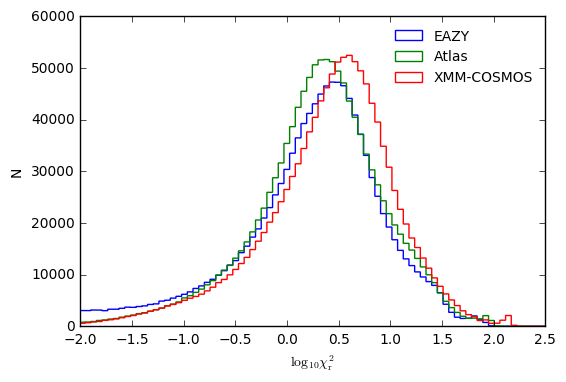

In [4]:
Fig, Ax = plt.subplots(1)
Ax.hist(np.log10(photoz['chi_r_eazy'][good]), bins=100, range=(-3,2.5), histtype='step', label='EAZY')
Ax.hist(np.log10(photoz['chi_r_atlas'][good]), bins=100, range=(-3,2.5), histtype='step', label='Atlas')
Ax.hist(np.log10(photoz['chi_r_cosmos'][good]), bins=100, range=(-3,2.5), histtype='step', label='XMM-COSMOS')
#Ax.hist(np.log10(photoz['chi_r_stellar']), bins=100, range=(-3,2.5), histtype='step')


Leg = Ax.legend(loc='upper right', prop={'size':10}, frameon=False)
Ax.set_xlabel(r'$\log_{10}\chi^{2}_{\rm{r}}$')
Ax.set_ylabel('N')
Ax.set_xlim([-2, 2.5])
Fig.savefig('plots/dmu24_Lockman-SWIRE_chi2_distributions.png', format='png', bbox_inches='tight')

#### Galaxy/AGN vs stellar templates - $\chi^{2}$ 

We now plot the distribution of 'Best' normalised $\chi^{2}$ from the Galaxy/AGN template libraries vs the normalised $\chi^{2}$ from fits to the Pickles library of stellar templates. Sources are split by apparent optical magnitude with the relative number of sources indicated in each panel.

/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/software/local/lib64/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/software/local/lib64/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


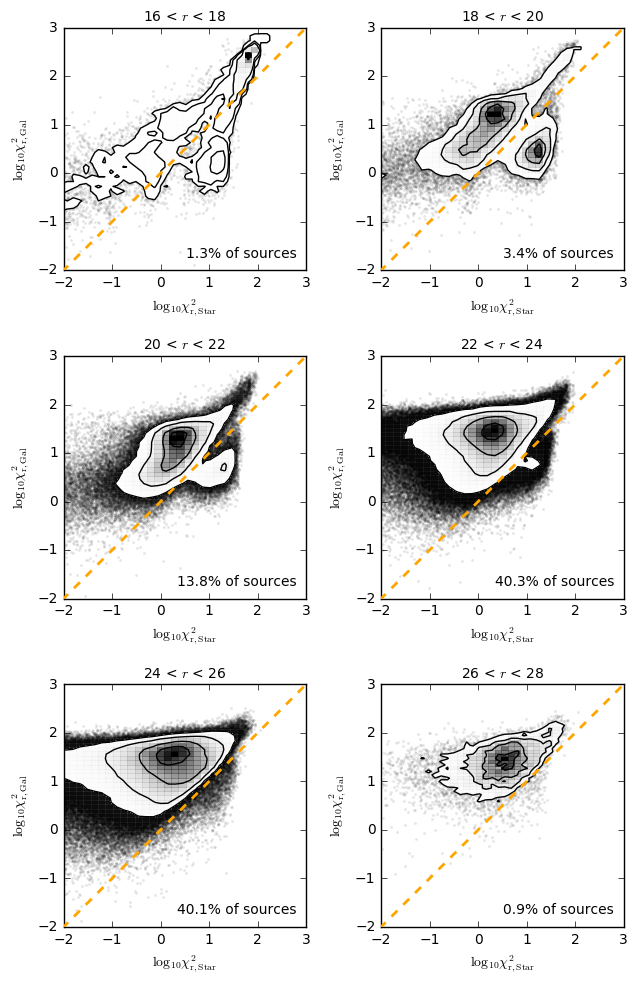

In [5]:
Fig, Ax = plt.subplots(3, 2, figsize=(6.5, 10))
mag_lims = [16, 18, 20, 22, 24, 26, 28]

for im in range(len(mag_lims)-1):
    ax = Ax.flatten()[im]
    ax.axes.set_aspect('equal')
    mag = np.logical_and(photometry['r_any_mag'] >= mag_lims[im], photometry['r_any_mag'] < mag_lims[im+1])

    fraction = (np.sum(mag*good) / np.sum(good).astype('float'))
    
    corner.hist2d(np.log10(best[good*mag]), np.log10(photoz['chi_r_stellar'])[good*mag], ax=ax, bins=50, 
              plot_datapoints=True, plot_density=True)
    ax.plot([-3,3],[-3,3], zorder=10000, color='orange', lw=2, ls='--')

    ax.set_xlim([-2, 3])
    ax.set_ylim([-2, 3])
    
    ax.set_title('{0:d} < {1} < {2:d}'.format(mag_lims[im], '$r$',mag_lims[im+1]), size=10)
    ax.set_xlabel(r'$\log_{10}\chi^{2}_{\rm{r, Star}}$')
    ax.set_ylabel(r'$\log_{10}\chi^{2}_{\rm{r, Gal}}$')
    ax.text(2.8, -1.8, '{0:.1f}% of sources'.format(fraction*100),
            horizontalalignment='right', verticalalignment='bottom')

Fig.tight_layout()
Fig.savefig('plots/dmu24_Lockman-SWIRE_chi2_galaxy_star_comparison.png', format='png', bbox_inches='tight')

### Photo-z vs Spec-z Visual Comparison
  
As plots of photo-z vs spec-z are commonly presented in order to allow the visual inspection of the relative precision and biases of photo-z estimates, we provide a version here for reference. However, instead of choosing a single value to represent the photometric redshift (e.g. median or peak of the $P(z)$) we stack the full $P(z)$ of all the sources within each spectroscopic redshift bin.

/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in divide


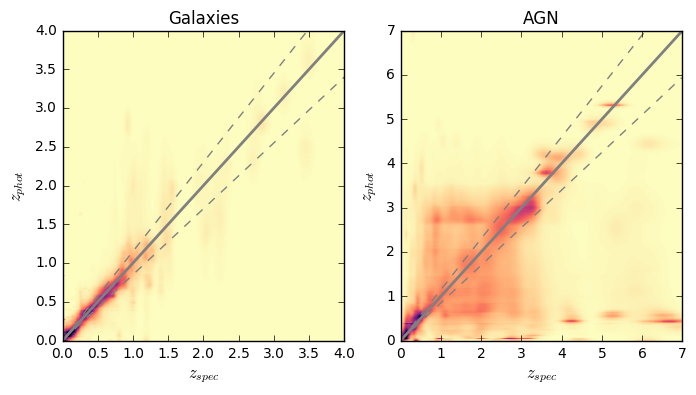

In [8]:
pz2d_gal = pz2d_stack(photoz_pdf[zs_gal,:], z_spec[zs_gal], photoz_zgrid, 5)
pz2d_agn = pz2d_stack(photoz_pdf[zs_agn,:], z_spec[zs_agn], photoz_zgrid, 10)  

Fig, Ax = plt.subplots(1, 2, figsize=(8,4))

X, Y = np.meshgrid(photoz_zgrid, photoz_zgrid)

Ax[0].pcolormesh(X, Y, pz2d_gal, cmap='magma_r', 
                 vmin=0, vmax=np.percentile(pz2d_gal, 99.9))

#             extent=[photoz_zgrid.min(), photoz_zgrid.max(), 
#             photoz_zgrid.min(), photoz_zgrid.max()], 

Ax[1].pcolormesh(X, Y, pz2d_agn, cmap='magma_r', 
             vmin=0, vmax=np.percentile(pz2d_agn, 99.9))

Ax[0].set_title('Galaxies')
Ax[1].set_title('AGN')

Ax[0].set_xlim([0, np.ceil(z_spec[zs_gal].max())])
Ax[0].set_ylim([0, np.ceil(z_spec[zs_gal].max())])

Ax[1].set_xlim([0, np.ceil(z_spec[zs_agn].max())])
Ax[1].set_ylim([0, np.ceil(z_spec[zs_agn].max())])


for ax in Ax:
    ax.set_xlabel('$z_{spec}$', size=12)
    ax.set_ylabel('$z_{phot}$', size=12)

    ax.plot(photoz_zgrid, photoz_zgrid, color='0.5', lw=2)
    ax.plot(photoz_zgrid, (1+0.15)*photoz_zgrid, color='0.5', ls='--')
    ax.plot(photoz_zgrid, (1-0.15)*photoz_zgrid, color='0.5', ls='--')
    
Fig.savefig('plots/dmu24_Lockman-SWIRE_specz_vs_photz_pz.png', format='png', bbox_inches='tight')

### Photo-z Statistics

Metrics for photometric redshift precision and accuracy are defined as in Duncan et al. (2017, and references therein).

| Metric | | Definition |
|----------------|-------------|----------------------|
|$\sigma_{f}$ | Scatter - all galaxies | $\text{rms}(\Delta z / (1+z_{\text{spec}}))$ |
|$\sigma_{\text{NMAD}}$ | Normalised median absolute deviation | $1.48 \times \text{median} ( \left | \Delta z \right | / (1+z_{\text{spec}}))$ |
|Bias | | $\text{median} (\Delta z )$|
|O$_{f}$ | Outlier fraction | Outliers defined as $\left | \Delta z \right | / (1+z_{\text{spec}}) > 0.2$ |
|$\sigma_{\text{O}_{f}}$ | Scatter excluding O$_{f}$ outliers |  $ \text{rms}[\Delta z / (1+z_{\text{spec}})]$ |
|$\overline{\rm{CRPS}}$ | Mean continuous ranked probability score | $\overline{\rm{CRPS}} = \frac{1}{N} \sum_{i=1}^{N} \int_{-\infty}^{+\infty} [ \rm{CDF}_{i}(z) -  \rm{CDF}_{z_{s},i}(z)]^{2} dz$ |


#### Quality statistics as a function of redshift


In [9]:
gal_z_binedges = np.linspace(0, np.ceil(np.percentile(z_spec[zs_gal],99)), 9)
agn_z_binedges = np.linspace(0, np.ceil(np.percentile(z_spec[zs_agn],99)), 9)

gal_z_bins = 0.5*(gal_z_binedges[:-1] + gal_z_binedges[1:])
agn_z_bins = 0.5*(agn_z_binedges[:-1] + agn_z_binedges[1:])

galaxy_statistics_vs_z = []
galaxy_crps_vs_z = []

for i, zmin in enumerate(gal_z_binedges[:-1]):
    zcut = np.logical_and(z_spec >= zmin, z_spec < gal_z_binedges[i+1])
    galaxy_statistics_vs_z.append(calcStats(photoz['z1_median'][zs_gal*zcut], z_spec[zs_gal*zcut]))
    
    pzs = photoz_pdf[zs_gal*zcut,:]
    zs = z_spec[zs_gal*zcut]
    galaxy_crps_vs_z.append(np.nanmean([ps.crps_ensemble(zs[i], 
                                                         forecasts=photoz_zgrid, 
                                                         weights=pzs[i]) for i in range(len(zs))]))
    
galaxy_statistics_vs_z = np.array(galaxy_statistics_vs_z)
    
agn_statistics_vs_z = []
agn_crps_vs_z = []

for i, zmin in enumerate(agn_z_binedges[:-1]):
    zcut = np.logical_and(z_spec >= zmin, z_spec < agn_z_binedges[i+1])
    agn_statistics_vs_z.append(calcStats(photoz['z1_median'][zs_agn*zcut], z_spec[zs_agn*zcut])) 

    pzs = photoz_pdf[zs_agn*zcut,:]
    zs = z_spec[zs_agn*zcut]
    agn_crps_vs_z.append(np.nanmean([ps.crps_ensemble(zs[i], 
                                                     forecasts=photoz_zgrid, 
                                                     weights=pzs[i]) for i in range(len(zs))]))
    
agn_statistics_vs_z = np.array(agn_statistics_vs_z)    

/home/duncan/.local/lib/python2.7/site-packages/properscoring/_crps.py:214: RuntimeWarning: Mean of empty slice
  weights = weights / np.nanmean(weights, axis=-1, keepdims=True)
/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:76: RuntimeWarning: invalid value encountered in double_scalars


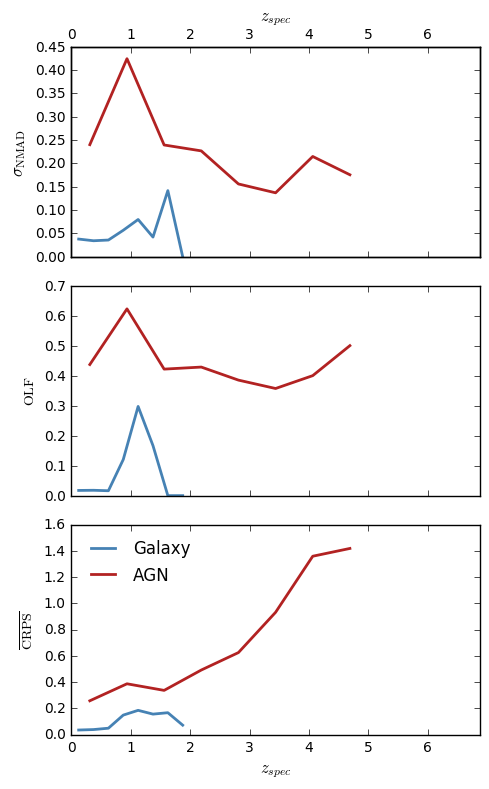

In [10]:
Fig, Ax = plt.subplots(3,1, sharex=True, figsize=(5,8))

Ax[0].plot(gal_z_bins, galaxy_statistics_vs_z[:,1], color='steelblue', lw=2, label='Galaxy')
Ax[0].plot(agn_z_bins, agn_statistics_vs_z[:,1], color='firebrick', lw=2, label='AGN')
Ax[0].set_ylabel(r'$\sigma_{\rm{NMAD}}$', size=12)

Ax[1].plot(gal_z_bins, galaxy_statistics_vs_z[:,3], color='steelblue', lw=2, label='Galaxy')
Ax[1].plot(agn_z_bins, agn_statistics_vs_z[:,3], color='firebrick', lw=2, label='AGN')
Ax[1].set_ylabel(r'$\rm{OLF}$')

Ax[2].plot(gal_z_bins, galaxy_crps_vs_z, color='steelblue', lw=2, label='Galaxy')
Ax[2].plot(agn_z_bins, agn_crps_vs_z, color='firebrick', lw=2, label='AGN')
Ax[2].set_ylabel(r'$\overline{\rm{CRPS}}$')

Leg = Ax[2].legend(loc='upper left', frameon=False)

Ax[2].set_xlim([0, z_spec[zs_agn].max()])
Ax[2].set_xlabel('$z_{spec}$', size=12)
Tw = Ax[0].twiny()
Tw.set_xlim([0, z_spec[zs_agn].max()])
Tw.set_xlabel('$z_{spec}$', size=12)

Fig.tight_layout()
Fig.savefig('plots/dmu24_Lockman-SWIRE_stats_vs_z.png', format='png', bbox_inches='tight')

#### Quality as a function of optical magnitude

In [12]:
zs_gal_mag = np.logical_and(z_spec >= 0, AGN == 0) * (photometry['r_any_mag'] > 0.)
zs_agn_mag = np.logical_and(z_spec >= 0, AGN == 1) * (photometry['r_any_mag'] > 0.)

gal_mag_binedges = np.linspace(*np.percentile(photometry['r_any_mag'][zs_gal_mag],[1,99]), num=9)
agn_mag_binedges = np.linspace(*np.percentile(photometry['r_any_mag'][zs_agn_mag],[1,99]), num=6)

gal_mag_bins = 0.5*(gal_mag_binedges[:-1] + gal_mag_binedges[1:])
agn_mag_bins = 0.5*(agn_mag_binedges[:-1] + agn_mag_binedges[1:])

galaxy_statistics_vs_mag = []
galaxy_crps_vs_mag = []

mag = photometry['r_any_mag']

for i, mmin in enumerate(gal_mag_binedges[:-1]):
    mcut = np.logical_and(mag >= mmin, mag < gal_mag_binedges[i+1])
    galaxy_statistics_vs_mag.append(calcStats(photoz['z1_median'][zs_gal_mag*mcut], z_spec[zs_gal_mag*mcut]))
    
    pzs = photoz_pdf[zs_gal_mag*mcut,:]
    zs = z_spec[zs_gal_mag*mcut]
    galaxy_crps_vs_mag.append(np.nanmean([ps.crps_ensemble(zs[i], 
                                                         forecasts=photoz_zgrid, 
                                                         weights=pzs[i]) for i in range(len(zs))]))
    
galaxy_statistics_vs_mag = np.array(galaxy_statistics_vs_mag)

agn_statistics_vs_mag = []
agn_crps_vs_mag = []

for i, mmin in enumerate(agn_mag_binedges[:-1]):
    mcut = np.logical_and(mag >= mmin, mag < agn_mag_binedges[i+1])
    agn_statistics_vs_mag.append(calcStats(photoz['z1_median'][zs_agn_mag*mcut], z_spec[zs_agn_mag*mcut])) 

    pzs = photoz_pdf[zs_agn_mag*mcut,:]
    zs = z_spec[zs_agn_mag*mcut]
    agn_crps_vs_mag.append(np.nanmean([ps.crps_ensemble(zs[i], 
                                                     forecasts=photoz_zgrid, 
                                                     weights=pzs[i]) for i in range(len(zs))]))
    
agn_statistics_vs_mag = np.array(agn_statistics_vs_mag)   

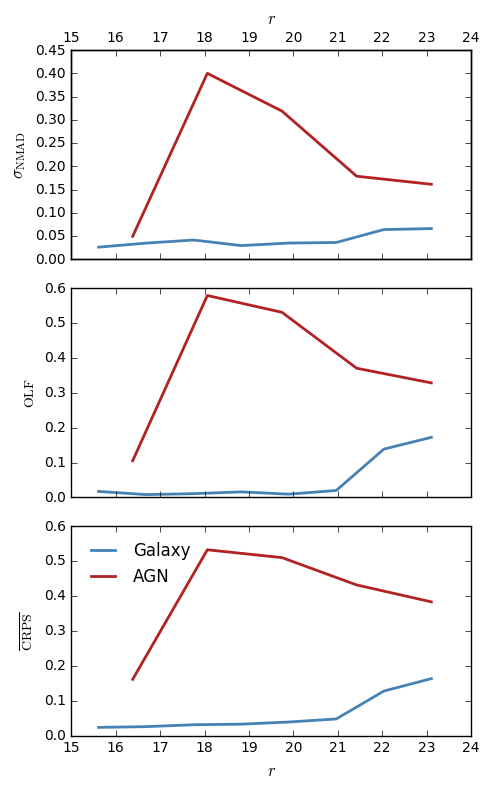

In [13]:
Fig, Ax = plt.subplots(3,1, sharex=True, figsize=(5,8))

Ax[0].plot(gal_mag_bins, galaxy_statistics_vs_mag[:,1], color='steelblue', lw=2, label='Galaxy')
Ax[0].plot(agn_mag_bins, agn_statistics_vs_mag[:,1], color='firebrick', lw=2, label='AGN')
Ax[0].set_ylabel(r'$\sigma_{\rm{NMAD}}$', size=12)

Ax[1].plot(gal_mag_bins, galaxy_statistics_vs_mag[:,3], color='steelblue', lw=2, label='Galaxy')
Ax[1].plot(agn_mag_bins, agn_statistics_vs_mag[:,3], color='firebrick', lw=2, label='AGN')
Ax[1].set_ylabel(r'$\rm{OLF}$')

Ax[2].plot(gal_mag_bins, galaxy_crps_vs_mag, color='steelblue', lw=2, label='Galaxy')
Ax[2].plot(agn_mag_bins, agn_crps_vs_mag, color='firebrick', lw=2, label='AGN')
Ax[2].set_ylabel(r'$\overline{\rm{CRPS}}$')

Leg = Ax[2].legend(loc='upper left', frameon=False)

#Ax[2].set_xlim([0, z_spec[zs_agn].max()])
Ax[2].set_xlabel('$r$', size=12)
Tw = Ax[0].twiny()
Tw.set_xlim(Ax[2].get_xlim())
Tw.set_xlabel('$r$', size=12)

Fig.tight_layout()
Fig.savefig('plots/dmu24_Lockman-SWIRE_stats_vs_mag.png', format='png', bbox_inches='tight')

### Accuracy of the photometric redshift probability distribution

Following Duncan et al. (2017) we calibrate the accuracy of the redshift PDF by scaling the input PDFs to the hierarchical Bayesian combination depending on the optical magnitude of a source in the band chosen for calibration. The diagnostic plot which best illustrates the overall redshift PDF accuracy is the Q-Q plot ($\hat{F}(c)$): 

>To quantify the over- or under-confidence of our photometric redshift estimates, we follow the example of Wittman et al. (2016) and calculate the distribution of threshold credible intervals, $c$, where the spectroscopic redshift is just included.
For a set of redshift PDFs which perfectly represent the redshift uncertainty (e.g. 10% of galaxies have the true redshift within the 10% credible interval, 20% within their 20% credible interval, etc.), the expected distribution of $c$ values should be constant between 0 and 1.
The cumulative distribution, $\hat{F}(c)$, should therefore follow a straight 1:1 relation.
Curves which fall below this expected 1:1 relation therefore indicate that there is overconfidence in the photometric redshift errors; the $P(z)$s are too sharp. - _Duncan et al. (2017)_

/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in less
/software/local/lib64/python2.7/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/software/local/lib64/python2.7/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


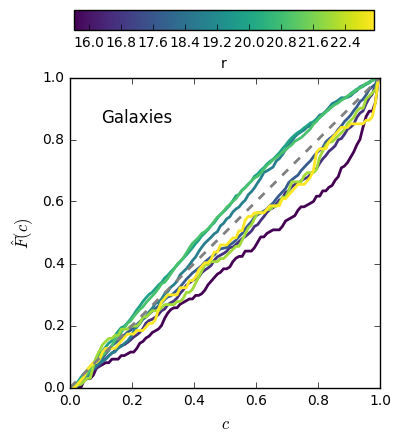

In [14]:
colors = plt.cm.viridis(np.linspace(0, 1, len(gal_mag_bins)))

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=gal_mag_bins.min(), vmax=gal_mag_bins.max())

Fig, Ax = plt.subplots(1)
for i, mmin in enumerate(gal_mag_binedges[:-1]):
    mcut = np.logical_and(mag >= mmin, mag < gal_mag_binedges[i+1])
    
    ci, bins = calc_ci_dist(photoz_pdf[zs_gal_mag*mcut,:], photoz_zgrid, z_spec[zs_gal_mag*mcut])
    
    Ax.plot(bins, ci, color=colors[i], lw=2)

cbax = Fig.add_axes([0.26, 1.02, 0.5, 0.05])
CB = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, norm=norm, orientation='horizontal')
CB.set_label('r')

Ax.set_aspect('equal')
Ax.set_ylim([0,1])
Ax.plot([0,1],[0,1], color='0.5', ls='dashed', lw=2)
Ax.set_xlabel(r'$c$', size=12)
Ax.set_ylabel(r'$\hat{F}(c)$', size=12)
Ax.text(0.1, 0.9, 'Galaxies', size=12,  verticalalignment='top')
Fig.savefig('plots/dmu24_Lockman-SWIRE_pz_accuracy_gal.png', format='png', bbox_inches='tight')

/software/local/lib64/python2.7/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in less


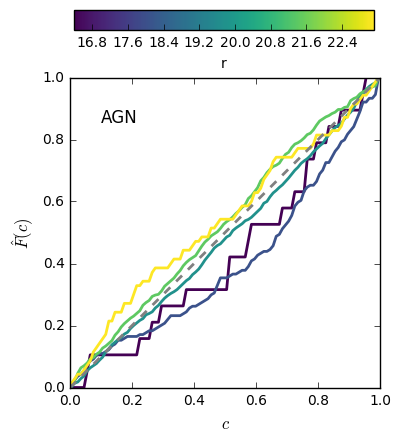

In [15]:
colors = plt.cm.viridis(np.linspace(0, 1, len(agn_mag_bins)))

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=agn_mag_bins.min(), vmax=agn_mag_bins.max())

Fig, Ax = plt.subplots(1)
for i, mmin in enumerate(agn_mag_binedges[:-1]):
    mcut = np.logical_and(mag >= mmin, mag < agn_mag_binedges[i+1])
    
    ci, bins = calc_ci_dist(photoz_pdf[zs_agn_mag*mcut,:], photoz_zgrid, z_spec[zs_agn_mag*mcut])
    
    Ax.plot(bins, ci, color=colors[i], lw=2)

#cbax = mpl.colorbar.make_axes(Ax.axes)
cbax = Fig.add_axes([0.26, 1.02, 0.5, 0.05])
CB = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, norm=norm, orientation='horizontal')
CB.set_label('r')

Ax.set_aspect('equal')
Ax.set_ylim([0,1])
Ax.plot([0,1],[0,1], color='0.5', ls='dashed', lw=2)
Ax.set_xlabel(r'$c$', size=12)
Ax.set_ylabel(r'$\hat{F}(c)$', size=12)
Ax.text(0.1, 0.9, 'AGN', size=12, verticalalignment='top')
Fig.savefig('plots/dmu24_Lockman-SWIRE_pz_accuracy_agn.png', format='png', bbox_inches='tight')